In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
from time import time

import dask
import dask.dataframe as dd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import seaborn as sns
from dask.distributed import Client, progress

In [3]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.io import cache_io, data_io
from src.loggers import logger
from src.plot.color_pal import SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

## Setup

In [5]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit="10GB")

In [6]:
data_path = data_io.data_path(data_io.DataFile.achilles_data)
if data_path.exists():
    print(f"data file: '{data_path.as_posix()}'")
else:
    raise FileNotFoundError(data_path)

data file: '/n/data1/hms/dbmi/park/Cook/speclet/modeling_data/depmap_modeling_dataframe.csv'


In [7]:
data_types: dict[str, str] = {"age": "float64"}
for a in ["p_dna_batch", "replicate_id", "primary_or_metastasis", "is_male"]:
    data_types[a] = "category"

achilles_data = dd.read_csv(data_path, dtype=data_types, low_memory=False)

## Basic statistics

In [8]:
achilles_data.head()

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,AAACCTGCGGCGGTCGCCA,OVR3_c905R1,-0.299958,CRISPR_C6596666.sample,chr8_66505451_-,VXN,sanger,True,8,66505451,...,0,NaN,NaN,NaN,False,0.847995,ovary,metastasis,FALSE,60.0
1,AACAGCACACCGGCCCCGT,OVR3_c905R1,0.267092,CRISPR_C6596666.sample,chrX_156009834_-,IL9R,sanger,True,X,156009834,...,0,NaN,NaN,NaN,False,0.700605,ovary,metastasis,FALSE,60.0
2,AACCTCCGGACTCCTCAGC,OVR3_c905R1,0.550477,CRISPR_C6596666.sample,chr7_39609658_-,YAE1,sanger,True,7,39609658,...,0,NaN,NaN,NaN,False,0.934918,ovary,metastasis,FALSE,60.0
3,AACTCAAACTGACGCCGAA,OVR3_c905R1,-0.391922,CRISPR_C6596666.sample,chr1_117623388_-,TENT5C,sanger,True,1,117623388,...,0,NaN,NaN,NaN,False,1.352975,ovary,metastasis,FALSE,60.0
4,AACTGACCTTGAAACGCTG,OVR3_c905R1,-1.562577,CRISPR_C6596666.sample,chr16_66933623_+,CIAO2B,sanger,True,16,66933623,...,0,NaN,NaN,NaN,False,1.259171,ovary,metastasis,FALSE,60.0


In [9]:
achilles_data.columns

Index(['sgrna', 'replicate_id', 'lfc', 'p_dna_batch', 'genome_alignment',
       'hugo_symbol', 'screen', 'multiple_hits_on_gene', 'sgrna_target_chr',
       'sgrna_target_pos', 'depmap_id', 'rna_expr', 'num_mutations',
       'any_deleterious', 'any_tcga_hotspot', 'any_cosmic_hotspot',
       'is_mutated', 'copy_number', 'lineage', 'primary_or_metastasis',
       'is_male', 'age'],
      dtype='object')

In [10]:
print("stats for all data:")

for col, lbl in {
    "sgrna": "sgRNA",
    "hugo_symbol": "genes",
    "depmap_id": "cell lines",
    "lineage": "lineages",
    "screen": "data sources",
}.items():
    count = len(achilles_data[col].unique().compute())
    print(f"  num {lbl}: {count:,}")

stats for all data:
  num sgRNA: 157,808
  num genes: 18,182
  num cell lines: 984
  num lineages: 27
  num data sources: 2


In [11]:
broad_achilles_data = achilles_data.query("screen == 'broad'")

In [12]:
print("stats for broad data:")

for col, lbl in {
    "sgrna": "sgRNA",
    "hugo_symbol": "genes",
    "depmap_id": "cell lines",
    "lineage": "lineages",
}.items():
    count = len(broad_achilles_data[col].unique().compute())
    print(f"  num {lbl}: {count:,}")

stats for broad data:
  num sgRNA: 71,062
  num genes: 18,119
  num cell lines: 853
  num lineages: 27


In [13]:
gene_sgrna_map = (
    broad_achilles_data[["hugo_symbol", "sgrna"]].drop_duplicates().compute()
)

In [14]:
gene_sgrna_map.groupby("hugo_symbol").count().reset_index(drop=False).describe()

,sgrna
count,18119.000000
mean,3.921960
std,0.384721
min,1.000000
25%,4.000000
50%,4.000000
75%,4.000000
max,11.000000


In [15]:
sampled_dataset = broad_achilles_data.sample(frac=0.001).compute()

In [16]:
sampled_dataset.shape

(60620, 22)

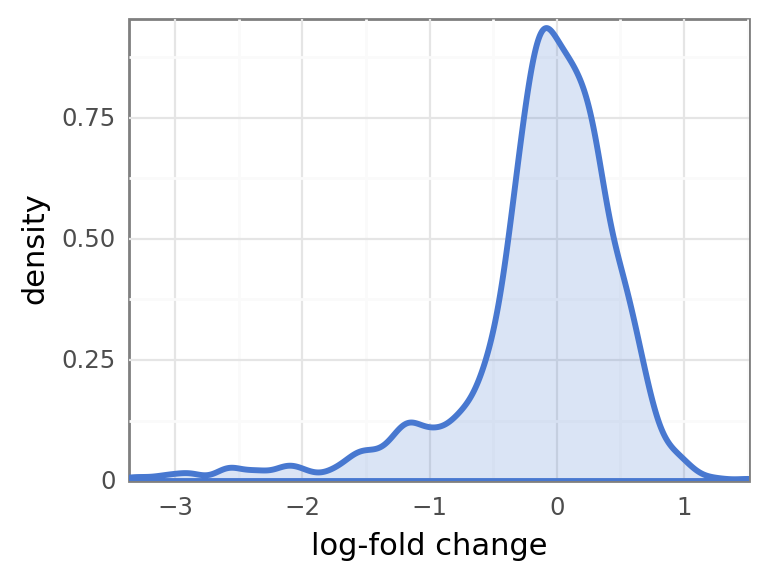

<ggplot: (8731168961003)>

In [17]:
(
    gg.ggplot(sampled_dataset.sample(n=1000), gg.aes(x="lfc"))
    + gg.geom_density(
        size=1.2,
        alpha=0.2,
        fill=SeabornColor.BLUE,
        color=SeabornColor.BLUE,
    )
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(4, 3))
    + gg.labs(x="log-fold change", y="density")
)

---

In [18]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 27.66 minutes


In [19]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-08-23

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: fix-theano-lock

numpy     : 1.21.2
dask      : 2021.8.0
pandas    : 1.3.2
seaborn   : 0.11.2
matplotlib: 3.4.3
plotnine  : 0.8.0

